In [1]:
import pandas as pd
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline, AutoTokenizer, AutoModel
import torch
from scipy.stats import pearsonr, spearmanr, linregress
from dotenv import load_dotenv
from sentence_transformers import SentenceTransformer


import os
import re
from tqdm import tqdm 
tqdm.pandas()

2025-02-18 18:15:35.569006: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-18 18:15:35.671429: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-18 18:15:35.713532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739888135.829629   21771 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739888135.864709   21771 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 18:15:36.095328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
def extract_experience(text):

    if text == '  Не указано':
        return None


    relevant_experience_match = re.search(r'релевантный опыт - (\d+ (?:год|года|лет) \d+ (?:месяц|месяца|месяцев)|\d+)', text)

    if relevant_experience_match:
        relevant_experience = relevant_experience_match.group(0)
    else:
        relevant_experience = text

    def convert_to_years(experience):
        years = 0
        months = 0
        
        year_match = re.search(r'(\d+) (?:год|года|лет)', experience)
        if year_match:
            years += int(year_match.group(1))
        
        month_match = re.search(r'(\d+) (?:месяц|месяца|месяцев)', experience)
        if month_match:
            months += int(month_match.group(1))

        years += round(months / 12, 2)
        return years

    return convert_to_years(relevant_experience)


def extract_last_job_title(text):
    pattern = r'(\d+\s*(?:месяцев|месяца|месяц|года|год|лет)\s*(?:и\s*\d+\s*(?:месяцев|месяца|месяц|года|год|лет))?\s*.*?Обязанности)'

    match = re.search(pattern, text)
    
    if match:
        experience = match.group(1)
        return re.sub(r'\d+\s*(?:месяцев|месяца|месяц|года|год|лет)\s*', ' ', experience).strip()[:-12]

    else:
        return None


def get_embeddings(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    
    with torch.no_grad():
        outputs = model(**inputs)
    

    embeddings = outputs.last_hidden_state.mean(dim=1).cpu()

    return embeddings


def last_now_jobs_similarity(row, model, tokenizer=None):
    if pd.isna(row['Последняя должность']):
        return None
    
    if isinstance(model, SentenceTransformer):
        embs1 = model.encode([row['Последняя должность']], convert_to_tensor=True)
        embs2 = model.encode([row['Должность']], convert_to_tensor=True)
    else:
        embs1 = get_embeddings(row['Последняя должность'], tokenizer, model)
        embs2 = get_embeddings(row['Должность'], tokenizer, model)
        
    return torch.nn.functional.cosine_similarity(
        embs1,
        embs2
    ).item()

In [3]:
pd.set_option('display.max_columns', 32)

In [4]:
load_dotenv()

username = os.environ.get('PG_USER')
password = os.environ.get('PG_PASSWORD')
dbname = os.environ.get('PG_DATABASE')
host = os.environ.get('PG_HOST')
port = os.environ.get('PG_PORT')

engine = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{dbname}')

In [5]:
df = pd.read_sql("""select * from "public"."Resume1";""", con=engine)

In [6]:
df.head(3)

,Дата_поступления,ФИО,Должность,Элпочта,Уровень_обр,Образование,Общий_стаж,Опыт_работы,ДПО,Сфера_деят,ЗП,Готов_приступить,Гражданство,Регион,График_работы,Тип_занятости,Переезд,Семейное_положение,Наличие_детей,Наличие_жилья,Владение_языками,Иные_документы,Результат,Нужен,Телефон,Дата
0,16.12.2024 09:58,ФКУ ИК-4 УФСИН России по Архангельской области,водитель автомобиля,rabotaik4@29.fsin.gov.ru,Среднее профессиональное,2004 Санкт-Петербургский профессиональный лице...,Общий стаж - 1 год 5 месяцев,январь 2024 – по настоящее время 11 месяцев во...,Не указано,"Транспорт, автобизнес, логистика, склад, ВЭД",от 50 000 руб.,с 24.06.2027,Российская Федерация,г. Санкт-Петербург,Полный рабочий день,Полная занятость,Не готов к переезду,не указано,нет детей,не нужно жилье,Русский язык — Родной,Водительское удостоверение категории B,None,Да,79532678497,2024-12-16
1,20.12.2024 14:06,Сухова Евгения Александровна,Мерчандайзер,nestleroma1@yandex.ru,Не указано,Не указано,Общий стаж - 1 месяц,ноябрь 2024 – декабрь 2024 1 месяц Мерчандайзе...,Не указано,"Продажи, закупки, снабжение, торговля",от 75 000 руб.,Не указано,Российская Федерация,г. Санкт-Петербург,Полный рабочий день,Полная занятость,Не готов к переезду,не указано,не указано,не указано,Не указано,Не указано,Принято,None,+7(991) 919-35-42,2024-12-20
2,13.12.2024 13:22,Беляев Андрей Евгеньевич,Специалист по Информационной Безопасности,andreyka0749@mail.ru,Не указано,Не указано,Не указано,Не указано,Не указано,"Безопасность, службы охраны",от 55 000 руб.,Не указано,Российская Федерация,г. Санкт-Петербург,Полный рабочий день,Полная занятость,Не указано,не указано,не указано,не указано,Русский язык — Базовый,,Принято,Нет,+7(911) 551-26-56,2024-12-13


In [7]:
df = df.drop_duplicates()

In [8]:
df['id'] = df['Телефон'] + df['ФИО']

In [9]:
df['id'].value_counts()

id
+7(991) 008-18-57Игумнова Татьяна Ивановна         20
+7(921) 904-27-62Битюков Валерий Михайлович         5
+7(921) 409-14-23Ласкателева Ирина Михайловна       5
  Не указаноМинакова Марья Вячеславовна             5
  Не указаноСтепанов Андрей Михайлович              4
                                                   ..
+7(921) 394-61-64Заркешева Жанна Эльтаевна          1
  Не указаноМищук Егор Юрьевич                      1
+7(991) 919-35-42Сухова Евгения Александровна       1
+7(981) 890-08-49Бураков Александр Владимирович     1
+7(911) 971-94-31КОЖУРОВ ОЛЕГ АЛЕКСАНДРОВИЧ         1
Name: count, Length: 905, dtype: int64

In [10]:
df[df['id'] == '+7(991) 008-18-57Игумнова Татьяна Ивановна']

,Дата_поступления,ФИО,Должность,Элпочта,Уровень_обр,Образование,Общий_стаж,Опыт_работы,ДПО,Сфера_деят,ЗП,Готов_приступить,Гражданство,Регион,График_работы,Тип_занятости,Переезд,Семейное_положение,Наличие_детей,Наличие_жилья,Владение_языками,Иные_документы,Результат,Нужен,Телефон,Дата,id
893,21.12.2024 12:51,Игумнова Татьяна Ивановна,Заместитель,tanya.igumnova.71@bk.ru,Высшее,"2005 ""Иркутский государственный университет"""" ...",Общий стаж - 6 лет 11 месяцев,сентябрь 2024 – декабрь 2024 3 месяца Заведующ...,Не указано,"Банки, кредит, страхование, пенсионное обеспеч...",от 85 000 руб.,Не указано,Российская Федерация,г. Санкт-Петербург,Полный рабочий день,Полная занятость,Не готов к переезду,Не в браке,есть дети,нужно жилье,Английский язык — Чтение и письмо со словарём,Водительское удостоверение категории B Медицин...,Принято,None,+7(991) 008-18-57,2024-12-21,+7(991) 008-18-57Игумнова Татьяна Ивановна
894,21.12.2024 12:52,Игумнова Татьяна Ивановна,Заместитель,tanya.igumnova.71@bk.ru,Высшее,"2005 ""Иркутский государственный университет"""" ...",Общий стаж - 6 лет 11 месяцев,сентябрь 2024 – декабрь 2024 3 месяца Заведующ...,Не указано,"Бухгалтерия, налоги, управленческий учет",от 85 000 руб.,Не указано,Российская Федерация,г. Санкт-Петербург,Полный рабочий день,Полная занятость,Не готов к переезду,Не в браке,есть дети,нужно жилье,Английский язык — Чтение и письмо со словарём,Водительское удостоверение категории B Медицин...,Принято,None,+7(991) 008-18-57,2024-12-21,+7(991) 008-18-57Игумнова Татьяна Ивановна
897,21.12.2024 12:55,Игумнова Татьяна Ивановна,Заместитель,tanya.igumnova.71@bk.ru,Высшее,"2005 ""Иркутский государственный университет"""" ...",Общий стаж - 6 лет 11 месяцев,сентябрь 2024 – декабрь 2024 3 месяца Заведующ...,Не указано,"Услуги населению, сервисное обслуживание",от 90 000 руб.,Не указано,Российская Федерация,г. Санкт-Петербург,Полный рабочий день,Полная занятость,Не готов к переезду,Не в браке,есть дети,нужно жилье,Английский язык — Чтение и письмо со словарём,Водительское удостоверение категории B Медицин...,Принято,None,+7(991) 008-18-57,2024-12-21,+7(991) 008-18-57Игумнова Татьяна Ивановна
898,21.12.2024 12:57,Игумнова Татьяна Ивановна,Заместитель,tanya.igumnova.71@bk.ru,Высшее,"2005 ""Иркутский государственный университет"""" ...",Общий стаж - 6 лет 11 месяцев,сентябрь 2024 – декабрь 2024 3 месяца Заведующ...,Не указано,"Государственная служба, некоммерческие организ...",от 75 000 руб.,Не указано,Российская Федерация,г. Санкт-Петербург,Полный рабочий день,Полная занятость,Не готов к переезду,Не в браке,есть дети,нужно жилье,Английский язык — Чтение и письмо со словарём,Водительское удостоверение категории B Медицин...,Принято,None,+7(991) 008-18-57,2024-12-21,+7(991) 008-18-57Игумнова Татьяна Ивановна
899,21.12.2024 12:59,Игумнова Татьяна Ивановна,Заместитель,tanya.igumnova.71@bk.ru,Высшее,"2005 ""Иркутский государственный университет"""" ...",Общий стаж - 6 лет 11 месяцев,сентябрь 2024 – декабрь 2024 3 месяца Заведующ...,Не указано,"Продажи, закупки, снабжение, торговля",от 85 000 руб.,Не указано,Российская Федерация,г. Санкт-Петербург,Полный рабочий день,Полная занятость,Не готов к переезду,Не в браке,есть дети,нужно жилье,Английский язык — Чтение и письмо со словарём,Водительское удостоверение категории B Медицин...,Принято,None,+7(991) 008-18-57,2024-12-21,+7(991) 008-18-57Игумнова Татьяна Ивановна
900,21.12.2024 13:14,Игумнова Татьяна Ивановна,Заместитель,tanya.igumnova.71@bk.ru,Высшее,"2005 ""Иркутский государственный университет"""" ...",Общий стаж - 6 лет 11 месяцев,сентябрь 2024 – декабрь 2024 3 месяца Заведующ...,Не указано,"Банки, кредит, страхование, пенсионное обеспеч...",от 85 000 руб.,Не указано,Российская Федерация,г. Санкт-Петербург,Полный рабочий день,Полная занятость,Не готов к переезду,Не в браке,есть дети,нужно жилье,Английский язык — Чтение и письмо со словарём,Водительское удостоверение категории B Медицин...,Принято,None,+7(991) 008-18-57,2024-12-21,+7(991) 008-18-57Игумнова Татьяна И

#### Телефоны повторяются с разницой времени в среднем 1 час, скорее всего человек несколько раз редактировал информацию о себе, буду брать последнюю отправку для каждого номера телефона

In [11]:
df = df.sort_values(by='Дата_поступления', ascending=False).drop_duplicates('id', keep='first')

#### Уберу признаки с персональными данными

In [12]:
df.drop(columns=['ФИО', 'Элпочта', 'Телефон', 'id'], inplace=True)

In [13]:
df.shape

(905, 23)

#### Распределение по дате

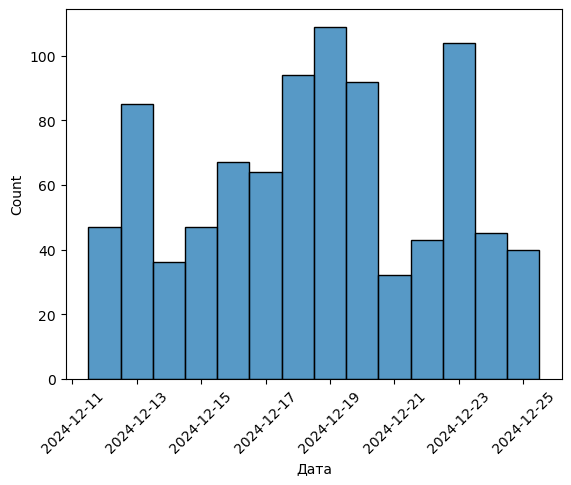

/tmp/ipykernel_21771/948590488.py:5: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sns.histplot(pd.to_datetime(df['Дата_поступления']))


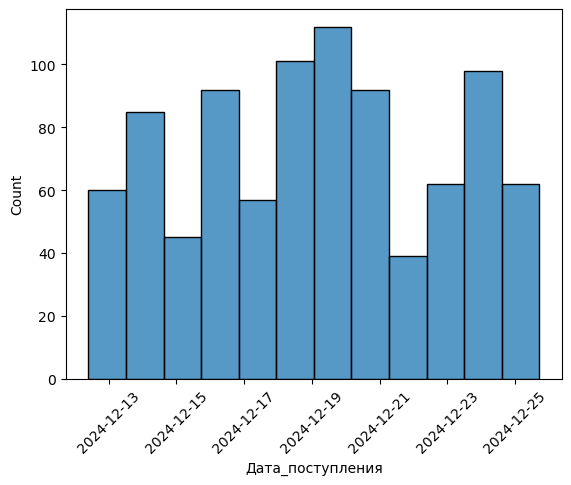

In [14]:
sns.histplot(df['Дата'])
plt.xticks(rotation=45) 
plt.show()

sns.histplot(pd.to_datetime(df['Дата_поступления']))
plt.xticks(rotation=45) 
plt.show()

#### Категориальные признаки

In [15]:
df['Уровень_обр'].value_counts()

Уровень_обр
Высшее                      451
Среднее профессиональное    157
Не указано                  135
Среднее                      48
Среднее общее                32
  Не указано                 30
Неоконченное высшее          15
Основное общее               15
Высшее Кандидат наук         13
Нет основного общего          9
Name: count, dtype: int64

In [16]:
df['Гражданство'].value_counts()

Гражданство
Российская Федерация    903
Республика Казахстан      2
Name: count, dtype: int64

In [17]:
df['Регион'].value_counts()

Регион
г. Санкт-Петербург    905
Name: count, dtype: int64

In [18]:
df['График_работы'].value_counts()

График_работы
Полный рабочий день                                                                                        481
Неполный рабочий день                                                                                       31
Сменный график, Полный рабочий день                                                                         27
Сменный график                                                                                              26
Полный рабочий день, Сменный график                                                                         26
                                                                                                          ... 
Гибкий график, Ненормированный рабочий день, Полный рабочий день, Неполный рабочий день                      1
Ненормированный рабочий день, Неполный рабочий день, Гибкий график, Полный рабочий день, Вахтовый метод      1
Ненормированный рабочий день, Полный рабочий день, Сменный график, Гибкий график                  

In [19]:
df['Тип_занятости'].value_counts()

Тип_занятости
Полная занятость       744
Частичная занятость     66
Удалённая               49
  Не указано            17
Временная               16
Стажировка              12
Сезонная                 1
Name: count, dtype: int64

In [20]:
df['Переезд'].value_counts()

Переезд
Не готов к переезду    865
  Не указано            40
Name: count, dtype: int64

In [21]:
df['Семейное_положение'].value_counts()

Семейное_положение
не указано    654
Не в браке    129
В браке       122
Name: count, dtype: int64

In [22]:
df['Наличие_детей'].value_counts()

Наличие_детей
не указано    659
есть дети     147
нет детей      99
Name: count, dtype: int64

In [23]:
df['Наличие_жилья'].value_counts()

Наличие_жилья
не указано        689
не нужно жилье    190
нужно жилье        26
Name: count, dtype: int64

In [24]:
df['Владение_языками'].value_counts()

Владение_языками
 Не указано                                        351
Английский язык — Базовый                          172
Русский язык — Родной                              126
Русский язык — Базовый                              84
Английский язык — Чтение и письмо со словарём       69
Английский язык — Способен пройти собеседование     35
Английский язык — Свободный                         23
Немецкий язык — Базовый                             12
Русский язык — Свободный                            10
Французский язык — Базовый                           5
Немецкий язык — Чтение и письмо со словарём          4
Испанский язык — Чтение и письмо со словарём         3
Немецкий язык — Способен пройти собеседование        3
Французский язык — Чтение и письмо со словарём       2
Испанский язык — Свободный                           2
Испанский язык — Базовый                             2
Русский язык — Чтение и письмо со словарём           1
Финский язык — Свободный                        

In [25]:
df['Нужен'].value_counts()

Нужен
Нет    160
Да      86
Name: count, dtype: int64

#### Уберу не информативные признаки (которые имеют 1 значение)

In [26]:
df.drop(columns=['Переезд', 'Регион'], inplace=True)

In [27]:
df.shape

(905, 21)

#### Числовые признаки

In [28]:
df['ЗП_от'] = df['ЗП'].str[3:-5].str.replace(' ', '').astype(int)
df.drop(columns=['ЗП'], inplace=True)

In [29]:
print((df['Общий_стаж'] == '  Не указано').mean())

0.23093922651933702


In [30]:
df['Общий_стаж_лет'] = df['Общий_стаж'].apply(extract_experience)
df.drop(columns=['Общий_стаж'], inplace=True)

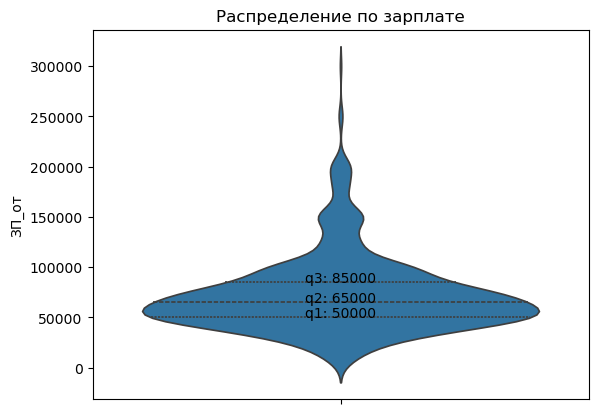

In [31]:
df_f = df[df['ЗП_от'].between(df['ЗП_от'].quantile(0.01), df['ЗП_от'].quantile(0.99))]

sns.violinplot(df_f, y='ЗП_от', inner='quartile')

q1 = df_f['ЗП_от'].quantile(0.25)
q2 = df_f['ЗП_от'].quantile(0.5)
q3 = df_f['ЗП_от'].quantile(0.75)


plt.text(0, q1, f"q1: {int(q1)}", horizontalalignment='center', size='medium', color='black')
plt.text(0, q2, f"q2: {int(q2)}", horizontalalignment='center', size='medium', color='black')
plt.text(0, q3, f"q3: {int(q3)}", horizontalalignment='center', size='medium', color='black')

plt.title('Распределение по зарплате')
plt.show()

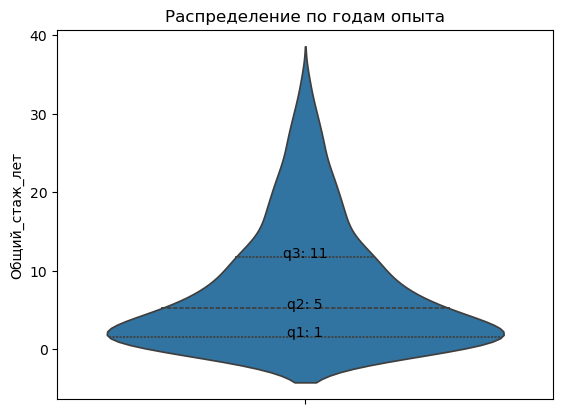

In [32]:
df_f = df[df['Общий_стаж_лет'].between(df['Общий_стаж_лет'].quantile(0.01), df['Общий_стаж_лет'].quantile(0.99))]

sns.violinplot(df_f, y='Общий_стаж_лет', inner='quartile')

q1 = df_f['Общий_стаж_лет'].quantile(0.25)
q2 = df_f['Общий_стаж_лет'].quantile(0.5)
q3 = df_f['Общий_стаж_лет'].quantile(0.75)


plt.text(0, q1, f"q1: {int(q1)}", horizontalalignment='center', size='medium', color='black')
plt.text(0, q2, f"q2: {int(q2)}", horizontalalignment='center', size='medium', color='black')
plt.text(0, q3, f"q3: {int(q3)}", horizontalalignment='center', size='medium', color='black')

plt.title('Распределение по годам опыта')
plt.show()

#### Таргет

In [33]:
df['Результат'].value_counts()

Результат
Принято      749
Отклонено      5
Name: count, dtype: int64

In [34]:
print(f'Доля пропусков в результате: {df["Результат"].isna().mean().__float__():.2f}')

Доля пропусков в результате: 0.17


In [35]:
print('Доля пропусков в результате:', df['Результат'].isna().sum().__int__())

Доля пропусков в результате: 151


#### Не принятый пример

In [36]:
df[df['Результат'] == 'Отклонено']

,Дата_поступления,Должность,Уровень_обр,Образование,Опыт_работы,ДПО,Сфера_деят,Готов_приступить,Гражданство,График_работы,Тип_занятости,Семейное_положение,Наличие_детей,Наличие_жилья,Владение_языками,Иные_документы,Результат,Нужен,Дата,ЗП_от,Общий_стаж_лет
126,22.12.2024 18:23,Штукатур,Среднее профессиональное,"2025 СПб, Академия реставрации и дизайна Специ...",Не указано,Не указано,"Административная работа, секретариат, АХО",Не указано,Российская Федерация,Полный рабочий день,Полная занятость,не указано,не указано,не указано,Русский язык — Базовый,,Отклонено,None,2024-12-22,50000,NaN
177,21.12.2024 17:58,Президент,Не указано,Не указано,Не указано,Не указано,"Административная работа, секретариат, АХО",с 08.02.2025,Российская Федерация,"Ненормированный рабочий день, Полный рабочий день",Удалённая,не указано,не указано,не указано,Не указано,Не указано,Отклонено,None,2024-12-21,100000,NaN
696,19.12.2024 12:42,Отдыхающий,Среднее общее,2024 Школа 170 Специальность: Строительство ж...,Не указано,Не указано,"Административная работа, секретариат, АХО",с 23.12.2024,Российская Федерация,Полный рабочий день,Полная занятость,не указано,есть дети,нужно жилье,Русский язык — Родной,Медицинская книжка,Отклонено,None,2024-12-19,90000,NaN
726,19.12.2024 12:30,Kawasaki H2r,Не указано,Не указано,март 2022 – март 2024 2 года ОООтмывденег Обяз...,Не указано,"Административная работа, секретариат, АХО",с 28.12.2024,Российская Федерация,Полный рабочий день,Полная занятость,не указано,не указано,не указано,Не указано,Не указано,Отклонено,None,2024-12-19,100000,2.0
12,13.12.2024 13:31,"Гендиректор ПАО ""Газпром""",Не указано,"Специальность: Строительство железных дорог, ...",Не указано,Не указано,"Строительство, ремонт, стройматериалы, недвижи...",с 22.12.2024,Российская Федерация,Полный рабочий день,Временная,не указано,не указано,не указано,Русский язык — Базовый,Не указано,Отклонено,Да,2024-12-13,999999,NaN


(Должность "Гендиректор ПАО Газпром" не адекватна для этого резюме)

#### Примеры с незаполненным таргетом

In [37]:
df[df['Результат'].isna()].head(3)

,Дата_поступления,Должность,Уровень_обр,Образование,Опыт_работы,ДПО,Сфера_деят,Готов_приступить,Гражданство,График_работы,Тип_занятости,Семейное_положение,Наличие_детей,Наличие_жилья,Владение_языками,Иные_документы,Результат,Нужен,Дата,ЗП_от,Общий_стаж_лет
1148,25.12.2024 17:10,водитель,Не указано,Не указано,апрель 2022 – октябрь 2022 6 месяцев Водитель ...,Не указано,"Транспорт, автобизнес, логистика, склад, ВЭД",с 09.01.2025,Российская Федерация,Полный рабочий день,Полная занятость,не указано,не указано,не указано,Не указано,Не указано,None,None,2024-12-25,80000,0.5
1147,25.12.2024 17:08,Веб-дизайнер,Высшее,2017 Санкт-Петербургский государственный аграр...,июль 2023 – сентябрь 2024 1 год 2 месяца админ...,2024 центр образовательных компетенций НТИ Наз...,"Информационные технологии, телекоммуникации, с...",Не указано,Российская Федерация,"Гибкий график, Полный рабочий день, Неполный р...",Удалённая,не указано,не указано,не указано,Английский язык — Базовый,Не указано,None,None,2024-12-25,70000,1.5
1146,25.12.2024 16:55,Редактор/сценарист,Не указано,Не указано,Не указано,Не указано,"Искусство, культура и развлечения",Не указано,Российская Федерация,Полный рабочий день,Полная занятость,не указано,не указано,не указано,Английский язык — Свободный,Не указано,None,None,2024-12-25,40000,NaN


In [38]:
print('\n\n'.join(df[df['Результат'].isna()]['Опыт_работы'].head(3).tolist()))

апрель 2022 – октябрь 2022 6 месяцев Водитель автомобиля. ИНДИВИДУАЛЬНЫЙ ПРЕДПРИНИМАТЕЛЬ ШЕВЧЕНКО МИХАИЛ ВЯЧЕСЛАВОВИЧ. Обязанности: возил грузы на машине

июль 2023 – сентябрь 2024 1 год 2 месяца администратор-кассир world class (ооо спорт форум) Обязанности: встреча клиентов, работа со звонками и обращениями, клиентская поддержка в клубе, урегулирование конфликтных ситуаций, расчетно-кассовые операции, ведение отчетности клуба, продажа фитнес-услуг и сопут.товаров, контроль процесса планирования  графика тренеров июль 2022 – ноябрь 2022 4 месяца администратор-кассир ип суворов (стар фитнес) Обязанности: Встреча клиентов;Консультирование клиентов по дополнительным товарам и услугам клуба;Прием и распределение телефонных звонков и прочей входящей информации; Принятие оплаты

  Не указано


#### Текстовые признаки

In [39]:
(df['Опыт_работы'] == '  Не указано').mean().__float__()

0.23093922651933702

In [40]:
(df['Должность'] == '  Не указано').mean()

np.float64(0.0)

In [41]:
(df['Образование'] == '  Не указано').mean().__float__()

0.13922651933701657

In [42]:
(df['ДПО'] == '  Не указано').mean().__float__()

0.8552486187845304

(из обязательных признаков 22% резюме не укзаываеют опыта работы)

#### Распределение по эмоциаональной окраске

Оценка окраски будет проводиться с помощью модели ```seara/rubert-tiny2-russian-sentiment```

In [44]:
model = pipeline(model="seara/rubert-tiny2-russian-sentiment", return_all_scores=True)

model.safetensors:   9%|8         | 10.5M/117M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cpu
/home/vladimir/miniconda3/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [77]:
df['text_data'] = 'Опыт работы: ' + df['Опыт_работы'] + '\n' + 'Желаемая должность: ' + df['Должность'] + '\n' + 'Образование: ' + df['Образование'] + '\n' + 'ДПО: ' + df['ДПО']

In [78]:
# df['text_data'] = df['text_data'].apply(lambda el: ' '.join(el.split(' ')[:1024]))

In [79]:
df['text_data'] = df['text_data'].apply(lambda el: re.sub(r"Предыдущее значение \d{2}\.\d{2}\.\d{4} ?", "", el))

In [53]:
df['sentiment'] = df['text_data'].progress_apply(model)

100%|██████████| 905/905 [00:25<00:00, 35.46it/s]


In [54]:
df['sentiment'] = df['sentiment'].apply(lambda results: {result['label']: result['score'] for result in results[0]})

In [55]:
df['neutral_sentiment'] = df['sentiment'].apply(lambda el: el['neutral'])

In [56]:
df['positive_sentiment'] = df['sentiment'].apply(lambda el: el['positive'])

In [57]:
df['negative_sentiment'] = df['sentiment'].apply(lambda el: el['negative'])

In [58]:
df['sentiment'] = df['sentiment'].apply(lambda el: max(el, key=el.get))

In [59]:
df['sentiment'].value_counts()

sentiment
neutral     890
positive     14
negative      1
Name: count, dtype: int64

In [60]:
print('\n\n'.join(df[df['sentiment'] == 'positive']['text_data'].to_list()))

Опыт работы: сентябрь 2023 – июнь 2024 9 месяцев педагог-психолог ГБОУ ЦО №167 г.Санкт-Петербург Обязанности: Коррекционно-развивающая работа в классах ОВЗ сентябрь 2018 – июнь 2023 4 года 9 месяцев педагог-психолог МАОУ «СШ №47 им. В.А. Тамгина» г. Хабаровска Обязанности: Психологическое сопровождение субъектов образовательного процесса, в т.ч. обучающихся с ОВЗ (диагностика, консультирование, занятия, методическая работа). Достижения: Опыт работы с обучающимися ОВЗ (ЗПР, УО, РАС,...), имеются готовые программы коррекции по основным направлениям. Опыт выступлений на методических площадках города по проблеме обучения и развития детей с ОВЗ. 1 квалификационная категория по должности "педагог-психолог".  Предыдущее значение Опыт работы с обучающимися ОВЗ (ЗПР, УО, РАС,...), имеются готовые программы коррекции по основным направлениям. Опыт выступлений на методических площадках города по проблеме обучения и развития детей с ОВЗ. 1 квалификационная категория по должности "педагог-психолог"

In [61]:
print('\n\n'.join(df[df['sentiment'] == 'negative']['text_data'].to_list()))

Опыт работы: январь 2011 – по настоящее время 13 лет 11 месяцев МКУ УГХ Обязанности: работа над бюджетом способствовала созданию более прозрачной и понятной финансовой отчетности для руководства. июль 2002 – январь 2011 8 лет 6 месяцев Отделение федерального казначейства Обязанности: Осуществляла санкционирование расходов бюджетных учреждений
Желаемая должность: Начальник финансового отдела
Образование:  Не указано 
ДПО:   Не указано


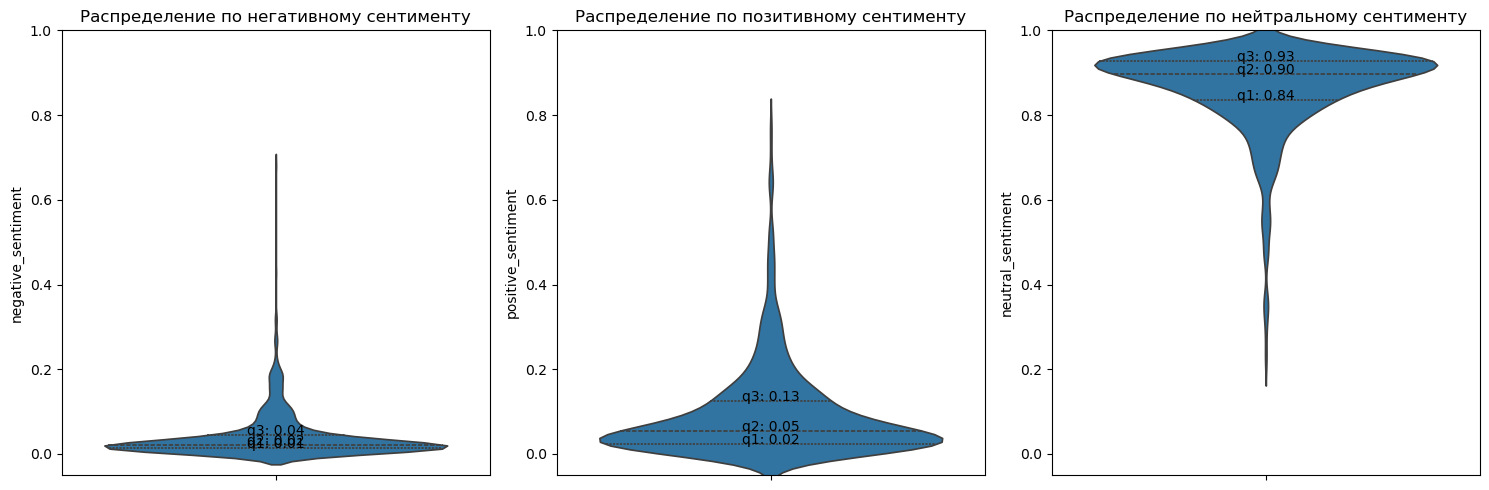

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

df_f = df.copy()

sns.violinplot(ax=axes[0], data=df_f, y='negative_sentiment', inner='quartile')
q1 = df_f['negative_sentiment'].quantile(0.25)
q2 = df_f['negative_sentiment'].quantile(0.5)
q3 = df_f['negative_sentiment'].quantile(0.75)
axes[0].text(0, q1, f"q1: {q1:.2f}", horizontalalignment='center', size='medium', color='black')
axes[0].text(0, q2, f"q2: {q2:.2f}", horizontalalignment='center', size='medium', color='black')
axes[0].text(0, q3, f"q3: {q3:.2f}", horizontalalignment='center', size='medium', color='black')
axes[0].set_title('Распределение по негативному сентименту')

sns.violinplot(ax=axes[1], data=df_f, y='positive_sentiment', inner='quartile')
q1 = df_f['positive_sentiment'].quantile(0.25)
q2 = df_f['positive_sentiment'].quantile(0.5)
q3 = df_f['positive_sentiment'].quantile(0.75)
axes[1].text(0, q1, f"q1: {q1:.2f}", horizontalalignment='center', size='medium', color='black')
axes[1].text(0, q2, f"q2: {q2:.2f}", horizontalalignment='center', size='medium', color='black')
axes[1].text(0, q3, f"q3: {q3:.2f}", horizontalalignment='center', size='medium', color='black')
axes[1].set_title('Распределение по позитивному сентименту')

sns.violinplot(ax=axes[2], data=df_f, y='neutral_sentiment', inner='quartile')
q1 = df_f['neutral_sentiment'].quantile(0.25)
q2 = df_f['neutral_sentiment'].quantile(0.5)
q3 = df_f['neutral_sentiment'].quantile(0.75)
axes[2].text(0, q1, f"q1: {q1:.2f}", horizontalalignment='center', size='medium', color='black')
axes[2].text(0, q2, f"q2: {q2:.2f}", horizontalalignment='center', size='medium', color='black')
axes[2].text(0, q3, f"q3: {q3:.2f}", horizontalalignment='center', size='medium', color='black')
axes[2].set_title('Распределение по нейтральному сентименту')

for ax in axes:
    ax.set_ylim(-0.05, 1)

plt.tight_layout()
plt.show()

#### Соответствие опыта и зарплаты

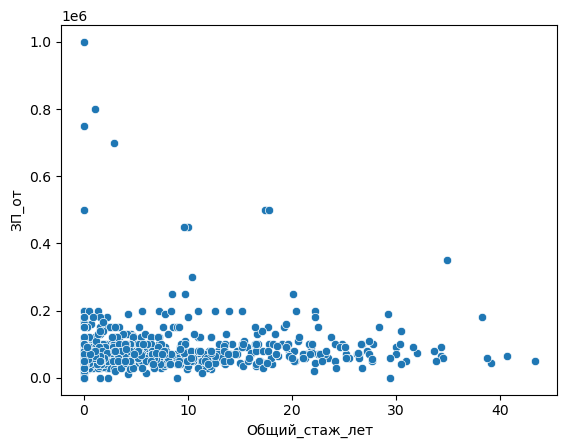

In [63]:
sns.scatterplot(x=df_f['Общий_стаж_лет'].fillna(0), y=df_f['ЗП_от'])
plt.show()

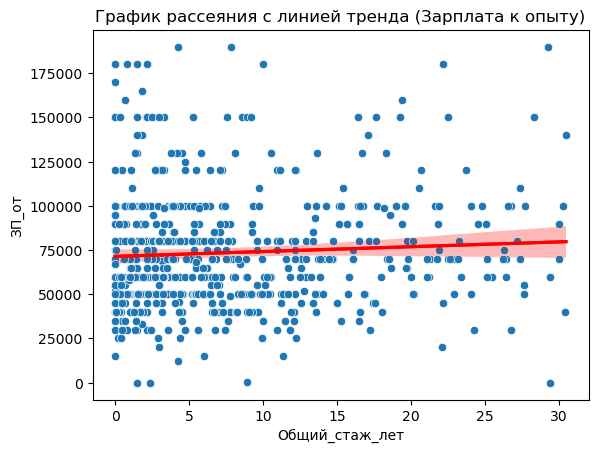

R²: 0.06
Корреляция Пирсона: 0.06
Корреляция Спирмена: 0.06
Накллон линии тренда: 272.08


In [64]:
df_f = df[(df['Общий_стаж_лет'] < df['Общий_стаж_лет'].quantile(0.98)) & (df['ЗП_от'] < df['ЗП_от'].quantile(0.98))]


sns.regplot(x=df_f['Общий_стаж_лет'].fillna(0), y=df_f['ЗП_от'], scatter=False, color='red')


sns.scatterplot(x=df_f['Общий_стаж_лет'].fillna(0), y=df_f['ЗП_от'])
plt.xlabel('Общий стаж (лет)')
plt.ylabel('Зарплата (от)')


sns.regplot(x=df_f['Общий_стаж_лет'].fillna(0), y=df_f['ЗП_от'], scatter=False, color='red')


pearson_corr, _ = pearsonr(df_f['Общий_стаж_лет'].fillna(0), df_f['ЗП_от'])
spearman_corr, _ = spearmanr(df_f['Общий_стаж_лет'].fillna(0), df_f['ЗП_от'])

slope, intercept, r_value, p_value, std_err = linregress(df_f['Общий_стаж_лет'], df_f['ЗП_от'])

plt.title('График рассеяния с линией тренда (Зарплата к опыту)')
plt.show()

print(f'R²: {r_value:.2f}')
print(f'Корреляция Пирсона: {pearson_corr:.2f}')
print(f'Корреляция Спирмена: {spearman_corr:.2f}')
print(f'Накллон линии тренда: {slope:.2f}')

In [65]:
df_f['Уровень_обр'].value_counts()

Уровень_обр
Высшее                      387
Среднее профессиональное    113
Не указано                   56
Среднее                      37
Среднее общее                15
Неоконченное высшее          13
  Не указано                 11
Основное общее               10
Высшее Кандидат наук         10
Нет основного общего          7
Name: count, dtype: int64

In [66]:
df_f = df_f.replace(
    {
        'Среднее общее': 'Среднее',
        'Неоконченное высшее': 'Среднее',
        'Высшее Кандидат наук': 'Высшее',
        '  Не указано': 'Не указано',
        'Нет основного общего': 'Не указано'
    }
)

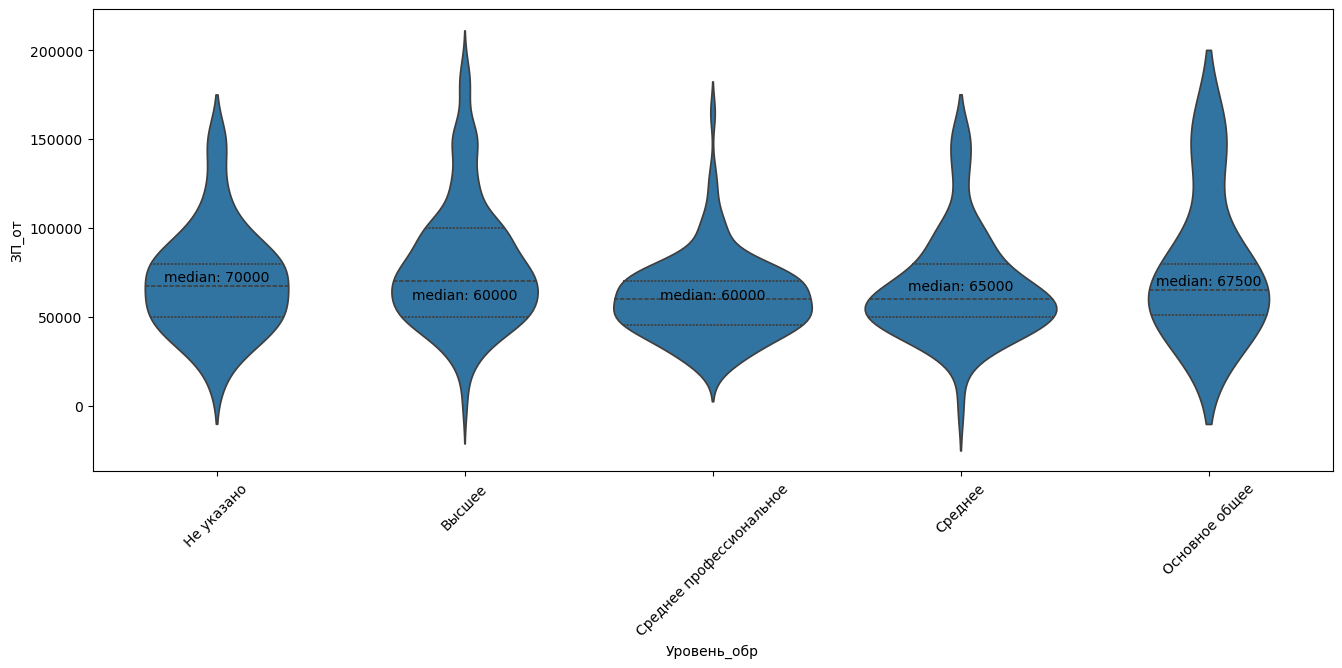

In [67]:

plt.figure(figsize=(16, 6))
plt.xticks(rotation=45)
sns.violinplot(x='Уровень_обр', y='ЗП_от', data=df_f, inner='quartile')


median_data = df_f.groupby('Уровень_обр')['ЗП_от'].median().loc[['Высшее', 'Среднее профессиональное', 'Среднее', 'Основное общее', 'Не указано']].reset_index()

for index, row in median_data.iterrows():
    plt.text(index, row['ЗП_от'], f"median: {row['ЗП_от']:.0f}", 
             horizontalalignment='center', size='medium', color='black')


plt.show()

#### Самое большое отношение ЗП к Опыту

In [68]:
df['зп_к_опыту'] = (df['ЗП_от'] / (df['Общий_стаж_лет'] + 1))
df.sort_values(by='зп_к_опыту', ascending=False).head(5)

,Дата_поступления,Должность,Уровень_обр,Образование,Опыт_работы,ДПО,Сфера_деят,Готов_приступить,Гражданство,График_работы,Тип_занятости,Семейное_положение,Наличие_детей,Наличие_жилья,Владение_языками,Иные_документы,Результат,Нужен,Дата,ЗП_от,Общий_стаж_лет,text_data,sentiment,neutral_sentiment,positive_sentiment,negative_sentiment,зп_к_опыту
15,12.12.2024 11:50,Специалист по документообороту,Высшее,2011 «Санкт-Петербургский государственный инст...,март 2014 – апрель 2015 1 год 1 месяц Менеджер...,Не указано,"Искусство, культура и развлечения",Не указано,Российская Федерация,Полный рабочий день,Полная занятость,не указано,не указано,не указано,Английский язык — Базовый,Не указано,Принято,Нет,2024-12-12,800000,1.08,Опыт работы: март 2014 – апрель 2015 1 год 1 м...,neutral,0.853974,0.138302,0.007724,384615.384615
689,22.12.2024 13:03,"Эксперт, консультант, руководитель подразделен...",Высшее,1994 ПВУРЭ ПВО г. Пушкин 2005 Высшая школа при...,январь 2022 – по настоящее время 2 года 11 мес...,Не указано,Юриспруденция,с 10.01.2025,Российская Федерация,"Неполный рабочий день, Полный рабочий день, См...",Полная занятость,не указано,не указано,не указано,Английский язык — Базовый,"Водительское удостоверение категории A, B, C",Принято,None,2024-12-22,200000,0.00,Опыт работы: январь 2022 – по настоящее время ...,neutral,0.892540,0.090331,0.017129,200000.000000
754,19.12.2024 20:41,Специалист,Высшее,2010 «Всероссийский заочный финансово-экономич...,"июль 2023 – июль 2023 Делопроизводитель ООО ""Э...",Не указано,"Бухгалтерия, налоги, управленческий учет",Не указано,Российская Федерация,Полный рабочий день,Полная занятость,не указано,не указано,не указано,Английский язык — Чтение и письмо со словарём,Не указано,Принято,None,2024-12-19,200000,0.00,Опыт работы: июль 2023 – июль 2023 Делопроизво...,neutral,0.884147,0.100939,0.014915,200000.000000
503,18.12.2024 12:22,Начальник ОТК,Высшее,2012 «Санкт-Петербургский государственный унив...,декабрь 2021 – декабрь 2024 3 года Начальник О...,Не указано,Производство,с 01.01.2025,Российская Федерация,Полный рабочий день,Полная занятость,не указано,не указано,не указано,Не указано,Не указано,Принято,None,2024-12-18,180000,0.00,Опыт работы: декабрь 2021 – декабрь 2024 3 год...,neutral,0.956876,0.020822,0.022302,180000.000000
1111,24.12.2024 22:20,Backend разработчик,Высшее,1998 Балтийский государственный технический ун...,апрель 2023 – июль 2023 3 месяца Старший прогр...,2023 Межрегиональный учебный центр инновационн...,"Информационные технологии, телекоммуникации, с...",Не указано,Российская Федерация,"Полный рабочий день, Неполный рабочий день",Полная занятость,не указано,не указано,не указано,Русский язык — Родной,Водительское удостоверение категории B Прошел ...,None,None,2024-12-24,180000,0.00,Опыт работы: апрель 2023 – июль 2023 3 месяца ...,neutral,0.877500,0.113065,0.009435,180000.000000


(несмотря на это все резюме приняты)

#### Проверю соответсвие прошлой должности и желаемой должности с помощью близости llm ембедингов

In [69]:
df['Последняя должность'] = df['Опыт_работы'].apply(extract_last_job_title)

In [70]:
embeddings_model = SentenceTransformer('intfloat/multilingual-e5-large')


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/160k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

In [71]:
df['Соответствие_опыта_должности'] = df\
.progress_apply(lambda row: last_now_jobs_similarity(row, embeddings_model), axis=1)

100%|██████████| 905/905 [06:03<00:00,  2.49it/s]


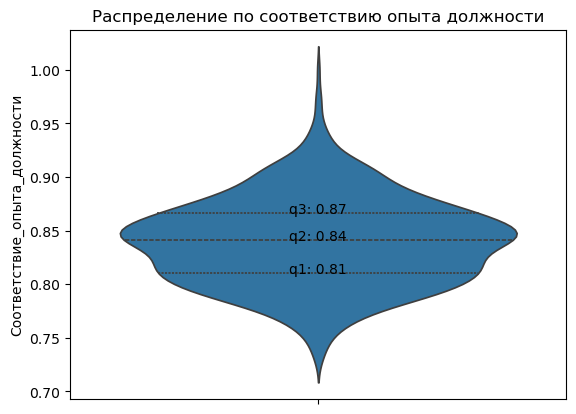

In [72]:
df_f = df.copy()

sns.violinplot(df_f, y='Соответствие_опыта_должности', inner='quartile')

q1 = df_f['Соответствие_опыта_должности'].quantile(0.25)
q2 = df_f['Соответствие_опыта_должности'].quantile(0.5)
q3 = df_f['Соответствие_опыта_должности'].quantile(0.75)


plt.text(0, q1, f"q1: {float(q1):.2f}", horizontalalignment='center', size='medium', color='black')
plt.text(0, q2, f"q2: {float(q2):.2f}", horizontalalignment='center', size='medium', color='black')
plt.text(0, q3, f"q3: {float(q3):.2f}", horizontalalignment='center', size='medium', color='black')

plt.title('Распределение по соответствию опыта должности')
plt.show()

Большинство резюме соответсвуют должностям

In [73]:
df.sort_values(by='Соответствие_опыта_должности')[['Последняя должность', 'Должность', 'Результат']].head(10)

,Последняя должность,Должность,Результат
339,Агент по недвижимости Эрмитаж. Галерея недвижи...,85 000,None
423,"Федеральная сеть магазинов у дома ""Красное & Б...",Аниматор,Принято
1064,Мастер по ремонту одежды ИП Логунова ТВ,Портной,None
460,Грузчик Европа маркет,Любая,Принято
997,Продавец-кассир ООО «Альфа-М»,Любая,Принято
745,"Продавец-кассир ТК ""Ракета"" г. Петергоф",Любая,Принято
1066,Судостроительный завод Северная Верфь,"кладовщик, комплектатор",None
1139,Различные организации Северо-Западного региона,Юрист,None
306,"Старший менеджер по продажам ООО ""УК Камелия"",...",графический дизайнер,Принято
956,проектная работа и обучение в Нетологии Нетология,Моушн-дизайнер,Принято


In [80]:
df.to_csv('data/processed_resume.csv')